In [1]:
%matplotlib widget

import time
from pacti_instrumentation.pacti_counters import summarize_instrumentation_data
from pacti_instrumentation.cpu_usage_plot import cpu_usage_plot
    
import numpy as np
from schedulability import *

from p_tqdm import p_umap
from scipy.stats import qmc

import pickle

Having generated 5-step scenario variants, we now turn to analyzing their schedulability with respect to variations of operational requirements as constraints on the system behavior. 

In [2]:
op_l_bounds = [
    90.0,  # power: low range of initial soc
    5.0,   # power: low range of exit soc at each step
    5.0,   # alloc: low range of delta t
    60.0,  # sci: low range of d
    40.0,  # nav: low range of u
    60.0,  # nav: low range of r
]
op_u_bounds = [
    100.0,  # power: high range of initial soc
    30.0,   # power: low range of exit soc at each step
    100.0,  # alloc: high range of delta t
    100.0,  # sci: high range of  d
    90.0,   # nav: high range of  u
    100.0,  # nav: high range of r
]

We use the Latin Hypercube sampler to generate `m` random combinations of requirement hyper-parameters. Schedulability analysis entails checking the compatibility of each of the `m` operational requirement variations against each of the  `n5` 5-step scenario variations previously created. For a given scenario contract, this compatibility check involves merging the contracts for each of the `m` operational requirements variations. The success of the contract merge operation determines the schedulability of the given scenario contract under the given operational requirements. To provide diagnostic feedback about non-schedulable combinations, we break down the operational requirements into 3 sets of requirement constraints that we merge successively until either all are merged or one of the requirement constraints fails to merge. In the latter case, we record the requirement constraint that cannot be merged as an explanation for the non-schedulable combination. 

We've observed that this iterative contract merge for all combinations of scenario and requirement contracts does not scale as nicely as scenario generation since the CPU utilization hovers just above 20% despite the large collection of independent combinations to analyze. This is due in part to the fact each schedulability analysis involves up to 3 contract merge operations whereas each 5-step scenario variant generation required creating 23 contracts combined via 12 contract composition and 5 contract merge operations. That is, there is significant overhead in parallelizing computationally small processes.

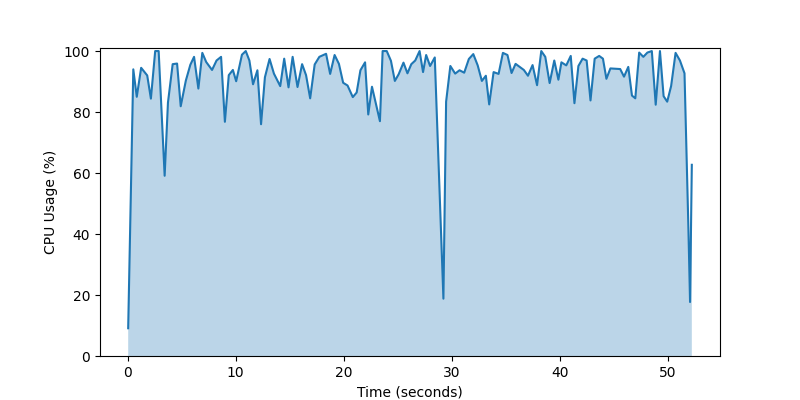

Output()

Found 0 admissible and 20000 non-admissible schedules out of 20000 combinations generated from 100 variations of operational requirements for each of the 200 scenarios.
Total time 52.20160436630249 running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.
Pacti compose,quotient,merge statistics:
no compose operations
no quotient operations
merge invocation counts: (min: 9, max: 9, avg: 9.0, total: 180000)
min/max merge contract size: (constraints: 1, variables: 1)/(constraints: 4, variables: 4)
Pacti PolyhedralTermList statistics:
no contains_behavior operations
Pacti PolyhedralCompoundContract statistics:
no compound_merge operations



In [3]:
op_sampler: qmc.LatinHypercube = qmc.LatinHypercube(d=len(op_l_bounds))

m = 100

op_sample: np.ndarray = op_sampler.random(n=m)
scaled_op_sample: np.ndarray = qmc.scale(sample=op_sample, l_bounds=op_l_bounds, u_bounds=op_u_bounds)

s5 = open("scenarios5.data", "rb")
scenarios5 = pickle.load(s5)
s5.close()

srs = [(scenario, req) for scenario in scenarios5 for req in scaled_op_sample]

K = 5  # Replace 5 with the desired group size

if K > 1:
    grouped_srs = [tuple(srs[i:i + K]) for i in range(0, len(srs), K)]
    with cpu_usage_plot(max_data_points=500, finally_clear_output=True):
        ta = time.time()
        results_g: List[List[Tuple[PactiInstrumentationData, schedule_result_t]]] = p_umap(schedulability_analysis5_grouped, grouped_srs)
        tb = time.time()

    flat_results = [result for group in results_g for result in group]
    stats = summarize_instrumentation_data([result[0] for result in flat_results])
    all_results5 = [result[1] for result in flat_results if result[1]]
else:
    with cpu_usage_plot(max_data_points=500, finally_clear_output=True):
        ta = time.time()
        results_ng: List[Tuple[PactiInstrumentationData, schedule_result_t]] = p_umap(schedulability_analysis5, srs)
        tb = time.time()

    stats = summarize_instrumentation_data([result[0] for result in results_ng])
    all_results5 = [result[1] for result in results_ng if result[1]]
    
results5: schedule_results_t = aggregate_schedule_results(all_results5)

print(
    f"Found {len(results5[1])} admissible and {len(results5[0])} non-admissible schedules out of {len(scaled_op_sample)*len(scenarios5)} combinations"
    f" generated from {len(scaled_op_sample)} variations of operational requirements for each of the {len(scenarios5)} scenarios.\n"
    f"Total time {tb-ta} running on {cpu_info_message}\n"
    f"{stats.stats()}"
)

f = open("results5.data", "wb")
pickle.dump(results5, f)
f.close()